In [2]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, TensorDataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
from sklearn.datasets import fetch_openml
CIFAR_10 = fetch_openml('CIFAR_10', data_home="./CIFAR_10_data") #version1のタグは不要

In [9]:
X = CIFAR_10.data / 255
y = CIFAR_10.target

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/6, random_state=0)

In [63]:
X_train[0].shape

torch.Size([50000, 3072])

In [11]:
X_train = transform(X_train) #数値データはTensor
X_test = transform(X_test)
y_train = torch.LongTensor(y_train.astype(np.int32)) #カテゴリカルデータはLongTensor。そのままだとobject型になっているのでnumpy.int型に変更
y_test = torch.LongTensor(y_test.astype(np.int32))

In [12]:
# これでudemyと同じ?
train_dataset = TensorDataset(X_train[0], y_train) #transformするとshapeが(1, *, *)になるので余分な1を取り除く
validation_dataset = TensorDataset(X_test[0], y_test)

In [13]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

In [14]:
len(names)

10

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [16]:
data_iter = iter(train_dataloader)
imgs, labels = data_iter.next()

In [17]:
labels

tensor([0, 8, 1, 3, 5, 3, 5, 8, 8, 5, 3, 3, 4, 0, 1, 9, 2, 4, 6, 6, 1, 7, 9, 4,
        8, 0, 3, 8, 2, 3, 8, 1])

In [18]:
imgs.size()

torch.Size([32, 3072])

In [43]:
img = imgs[2]

In [46]:
img_permute = img.view(3, 32, 32).permute(1, 2, 0)#* 0.5 + 0.5
#img_permute = np.clip(img_permute, 0, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


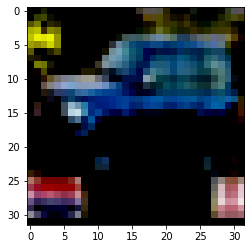

In [47]:
plt.imshow(img_permute)

In [56]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), ##16*16になる
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), ##8*8になる
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), ##4*4になる
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) #(batch, 4*4*128)
        x = self.classifier(x)
        return x



In [57]:
model = CNN(10)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) ##weight_decay:L2正則化
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.
    running_acc = 0.
    for imgs, labels in train_dataloader:
        imgs = imgs.view(-1, 3, 32, 32).to(device, dtype=torch.float)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    #
    # validation loop
    #
    val_running_loss = 0.
    val_running_acc = 0.
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.view(-1, 3, 32, 32).to(device, dtype=torch.float)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))


epoch: 0, loss: 0.7275856936675802, acc: 0.7475407719612122, val loss: 0.7502826287533148, val acc: 0.7432108521461487
epoch: 1, loss: 0.6263746167518204, acc: 0.7802903056144714, val loss: 0.7408162549661752, val acc: 0.7445087432861328
epoch: 2, loss: 0.5526447759623033, acc: 0.8050623536109924, val loss: 0.710385938088734, val acc: 0.7635782361030579
epoch: 3, loss: 0.483546895237779, acc: 0.8318138122558594, val loss: 0.7315831397192928, val acc: 0.7620806694030762
epoch: 4, loss: 0.4335441151854325, acc: 0.8494482040405273, val loss: 0.6964345832411855, val acc: 0.7662739753723145
epoch: 5, loss: 0.39592814242904645, acc: 0.8607445359230042, val loss: 0.7489707640375192, val acc: 0.761681318283081
epoch: 6, loss: 0.35320744363165635, acc: 0.874940037727356, val loss: 0.6974951599162227, val acc: 0.7752595543861389
epoch: 7, loss: 0.3245437976761804, acc: 0.8860764503479004, val loss: 0.7660728968180026, val acc: 0.7706668972969055
epoch: 8, loss: 0.293580877436748, acc: 0.89663308

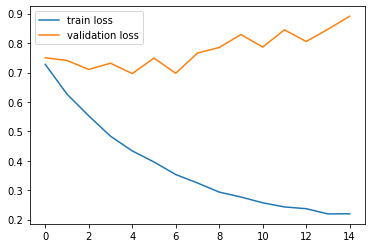

In [75]:
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

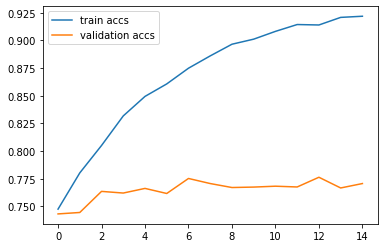

In [74]:
plt.plot(accs, label="train accs")
plt.plot(val_accs, label="validation accs")
plt.legend()

# データ拡張